In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jun 12 02:21:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Specify the current work folder
import os
os.chdir("/content/drive/MyDrive/Anti_xgboost/") 

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 34.7 MB/s eta 0:00:00


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
import matplotlib.pylab as pl
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import shap

In [ ]:
titanic = pd.read_csv('./Anti_MD.csv')
print(titanic.shape)
titanic.head()

(2928, 614)


,Anti,smiles,cas,MW,AMW,nTA,nBT,nBM,RBN,nDB,...,s2_numSharedNeighbors,s3_numSharedNeighbors,s4_numSharedNeighbors,s2_numRotBonds,s3_numRotBonds,s4_numRotBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,chiralMoment
0,0,[N-]=[N+]=CC(=O)OCC(N)C(=O)O,1,173.15,9.113158,5,18,4,5,4,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,10.723805
1,0,[O-][N+](=O)c1ncc[nH]1,2,113.09,10.280909,2,11,7,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0,[O-][n+]1cccc(CO)c1,3,125.14,7.821250,2,16,6,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0,Br.CC(Cc1ccc(O)cc1)NCC(O)c1cc(O)cc(O)c1,4,384.30,8.540000,5,45,12,6,0,...,0.0,0.0,0.0,0.0,0.5,3.5,0.0,6.0,6.0,19.874607
4,0,Br.Cc1ccc(Sc2ccccc2N2CCNCC2)c(C)c1,5,379.40,8.431111,2,46,12,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [ ]:
# Rhow dataframe column names
names = titanic.columns.values[3:614]

In [ ]:
y = titanic.loc[:,'Anti']
X = titanic.loc[:, 'MW':'chiralMoment']

In [ ]:
display(X.head())
print('Survived class distribution: \n', y.value_counts(normalize = True),'\n')

,MW,AMW,nTA,nBT,nBM,RBN,nDB,nAB,nN,nO,...,s2_numSharedNeighbors,s3_numSharedNeighbors,s4_numSharedNeighbors,s2_numRotBonds,s3_numRotBonds,s4_numRotBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,chiralMoment
0,173.15,9.113158,5,18,4,5,4,0,3,4,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,10.723805
1,113.09,10.280909,2,11,7,1,2,5,3,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,125.14,7.821250,2,16,6,1,0,6,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,384.30,8.540000,5,45,12,6,0,12,1,4,...,0.0,0.0,0.0,0.0,0.5,3.5,0.0,6.0,6.0,19.874607
4,379.40,8.431111,2,46,12,3,0,12,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Survived class distribution: 
 0    0.901981
1    0.098019
Name: Anti, dtype: float64 



In [ ]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
xgbcl = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0,base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
         gamma=0.0, max_delta_step=0.0, min_child_weight=1.0,
         n_jobs=-1, objective='binary:logistic', random_state=42, reg_alpha=0.0,
         reg_lambda=1.0, scale_pos_weight=1.0)

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = { 
    'colsample_bytree':[.75,1],
    'learning_rate':[0.01,0.05,0.1,0.3,0.5],
    'max_depth':[1,2,3,5],
    'subsample':[.75,1],
    'n_estimators': list(range(50, 400, 50))
}

In [ ]:
grid_search = GridSearchCV(estimator=xgbcl, scoring='roc_auc', param_grid=param_grid, n_jobs=-1, cv=kfold,verbose=1)

In [ ]:
grid_result = grid_search.fit(X_train, y_train)
print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}','\n')

In [ ]:
#Set our final hyperparameters to the tuned values
xgbcl = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
         gamma=0.0, max_delta_step=0.0, min_child_weight=1.0,
         n_jobs=-1, objective='binary:logistic', random_state=42, reg_alpha=0.0,
         reg_lambda=1.0, scale_pos_weight=1.0, tree_method='auto',
         #colsample_bytree = grid_result.best_params_['colsample_bytree'], 
         #learning_rate = grid_result.best_params_['learning_rate'], 
         #max_depth = grid_result.best_params_['max_depth'], 
         #subsample = grid_result.best_params_['subsample'], 
         #n_estimators = grid_result.best_params_['n_estimators']
         colsample_bytree = 0.75, 
         learning_rate = 0.1, 
         max_depth =2, 
         subsample = 0.75, 
         n_estimators = 150                         
                         )

#refit the model on k-folds to get stable avg error metrics
scores = cross_validate(estimator=xgbcl, X=X_train, y=y_train, cv=kfold, n_jobs=-1, 
                        scoring=['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])

print('Training 5-fold Cross Validation Results:\n')
print('AUC: ', scores['test_roc_auc'].mean())
print('Accuracy: ', scores['test_accuracy'].mean())
print('Precision: ', scores['test_precision'].mean())
print('Recall: ', scores['test_recall'].mean())
print('F1: ', scores['test_f1'].mean(), '\n')

Training 5-fold Cross Validation Results:

AUC:  0.930376908540573
Accuracy:  0.9548387096774194
Precision:  0.844176162002249
Recall:  0.6701015965166908
F1:  0.7453521196525615 



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=488, test_size=0.1)
#Fit the final model
xgbcl.fit(X_train, y_train)
#Generate predictions against our training and test data
pred_train = xgbcl.predict(X_train)
proba_train = xgbcl.predict_proba(X_train)
pred_test = xgbcl.predict(X_test)
proba_test = xgbcl.predict_proba(X_test)

# Print model report
print("Classification report (Test): \n")
print(metrics.classification_report(y_test, pred_test))
print ('\nTrain Accuracy:', metrics.accuracy_score(y_train, pred_train))
print ('Test Accuracy:', metrics.accuracy_score(y_test, pred_test))

print("Confusion matrix (Test): \n")
print(metrics.confusion_matrix(y_test, pred_test))

# calculate the fpr and tpr for all thresholds of the classification
train_fpr, train_tpr, train_threshold = metrics.roc_curve(y_train, proba_train[:,1])
test_fpr, test_tpr, test_threshold = metrics.roc_curve(y_test, proba_test[:,1])

train_roc_auc = metrics.auc(train_fpr, train_tpr)
test_roc_auc = metrics.auc(test_fpr, test_tpr)


#print ('\nTrain AUC:', train_roc_auc)
print ('Test AUC:', test_roc_auc)

train_precision, train_recall, _ = metrics.precision_recall_curve(y_train, proba_train[:,1])
test_precision, test_recall, _ = metrics.precision_recall_curve(y_test, proba_test[:,1])
train_ap = metrics.auc(train_recall, train_precision)
test_ap = metrics.auc(test_recall, test_precision)

#print ('\nTrain ap:', train_ap)
print ('Test ap:', test_ap)

Classification report (Test): 

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       267
           1       1.00      0.69      0.82        26

    accuracy                           0.97       293
   macro avg       0.99      0.85      0.90       293
weighted avg       0.97      0.97      0.97       293


Train Accuracy: 0.9772296015180265
Test Accuracy: 0.9726962457337884
Confusion matrix (Test): 

[[267   0]
 [  8  18]]
Test AUC: 0.9029098242581389
Test ap: 0.7928265429541295


In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=[7,5])
plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, 'b', label = 'Train AUC = %0.2f' % train_roc_auc)
plt.plot(test_fpr, test_tpr, 'g', label = 'Test AUC = %0.2f' % test_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# # plot feature importance
# xgb.plot_importance(xgbcl, importance_type='gain');

In [ ]:
# Compute the confusion matrix for true labels and predicted labels
cm=metrics.confusion_matrix(y_test, pred_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # Normalize the confusion matrix by row 
cm

array([[1.        , 0.        ],
       [0.30769231, 0.69230769]])

In [ ]:
#take a random row of data
X_rand = X.sample(1, random_state = 5)
display(titanic.iloc[X_rand.index])

#generate a prediction for the row
rand_pred = xgbcl.predict(X_rand)
rand_proba = xgbcl.predict_proba(X_rand)

print(f'Predicted Probability (no, yes): {rand_proba}')
print(f'Predicted Survival (0 = no, 1 = yes): {rand_pred}','\n')

,Anti,smiles,cas,MW,AMW,nTA,nBT,nBM,RBN,nDB,...,s2_numSharedNeighbors,s3_numSharedNeighbors,s4_numSharedNeighbors,s2_numRotBonds,s3_numRotBonds,s4_numRotBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,chiralMoment
2689,1,CCn1nc(C(=O)O)c(=O)c2cc3c(cc21)OCO3,2690,262.24,9.042759,4,31,9,2,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Predicted Probability (no, yes): [[0.4553784 0.5446216]]
Predicted Survival (0 = no, 1 = yes): [1] 



In [ ]:
import shap

explainer = shap.TreeExplainer(xgbcl, model_output='probability', feature_dependence='independent', data=X)
shap_values = explainer.shap_values(X.iloc[X_rand.index])
shap.initjs()
display(shap.force_plot(explainer.expected_value, shap_values, X.iloc[X_rand.index]))

#Display all features and SHAP values
display(pd.DataFrame(data=shap_values, columns=X.columns, index=[126]).transpose().sort_values(by=126, ascending=True))

feature_dependence = "independent" has been renamed to feature_perturbation = "interventional"! See GitHub issue #882.


,126
P_VSA_MR_2,-0.031137
SHED_PL,-0.022164
F08_N-O_,-0.019461
nR=Ct,-0.012955
SpMax_H2,-0.011382
...,...
CATS2D_04_AA,0.027670
H-048,0.033343
CATS2D_07_AN,0.042635
mindssC,0.047549


In [ ]:
#Prove the sum of SHAP values and base_value sum to our prediction for class 1
import math
shap_sum = explainer.expected_value + shap_values.sum()
assert(math.isclose(shap_sum,rand_proba[0][1],rel_tol=1e-06)) #if this was False, and error would be thrown

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


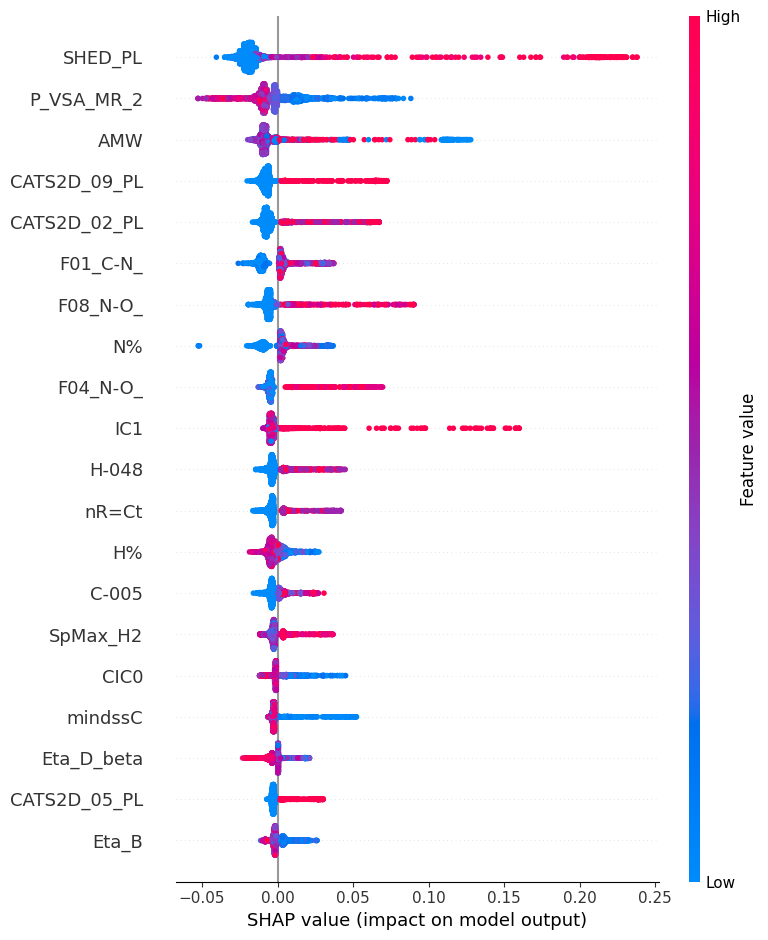

In [ ]:
import matplotlib.pyplot as pl
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X,max_display=20,show=False)
pl.savefig("shap_summary.svg",dpi=1200) #.png,.pdf will also support here
pl.show()